In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Generate Synthetic Data
np.random.seed(42)
N = 20585

def generate_responses(n_items, n_obs):
    # Simulate realistic correlation: people with one symptom usually have others
    latent_trait = np.random.gamma(shape=2, scale=2, size=n_obs) # Underlying distress
    data = {}
    for i in range(1, n_items + 1):
        # Map latent trait to 0-3 scale with some noise
        item_scores = np.clip(np.round(latent_trait * 0.5 + np.random.normal(0, 0.5, n_obs)), 0, 3)
        data[f'Item_{i}'] = item_scores.astype(int)
    return pd.DataFrame(data)

# Create GAD-7 and PHQ-9 dataframes
df_gad = generate_responses(7, N).rename(columns={f'Item_{i}': f'GAD{i}' for i in range(1, 8)})
df_phq = generate_responses(9, N).rename(columns={f'Item_{i}': f'PHQ{i}' for i in range(1, 10)})

# 2. Define Ground Truth Severity (As per the paper)
# GAD Cutoffs: 0-9 (Min/Mild), 10-14 (Moderate), 15-21 (Severe)
df_gad['Total'] = df_gad.sum(axis=1)
df_gad['Severity'] = pd.cut(df_gad['Total'], bins=[-1, 9, 14, 21], labels=['Min/Mild', 'Moderate', 'Severe'])

# PHQ Cutoffs: 0-9 (Min/Mild), 10-14 (Mod), 15-27 (Severe/Mod-Severe)
df_phq['Total'] = df_phq.sum(axis=1)
df_phq['Severity'] = pd.cut(df_phq['Total'], bins=[-1, 9, 14, 27], labels=['Min/Mild', 'Moderate', 'Severe'])

In [ ]:
# 3. Model Setup for GAD-7
X = df_gad.drop(['Total', 'Severity'], axis=1)
y = df_gad['Severity']

# 70/30 Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Replicating hyperparameter configuration: minbucket=500 (min_samples_leaf)
clf = DecisionTreeClassifier(
    criterion='gini',
    min_samples_leaf=500,
    min_samples_split=1000,
    random_state=42
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

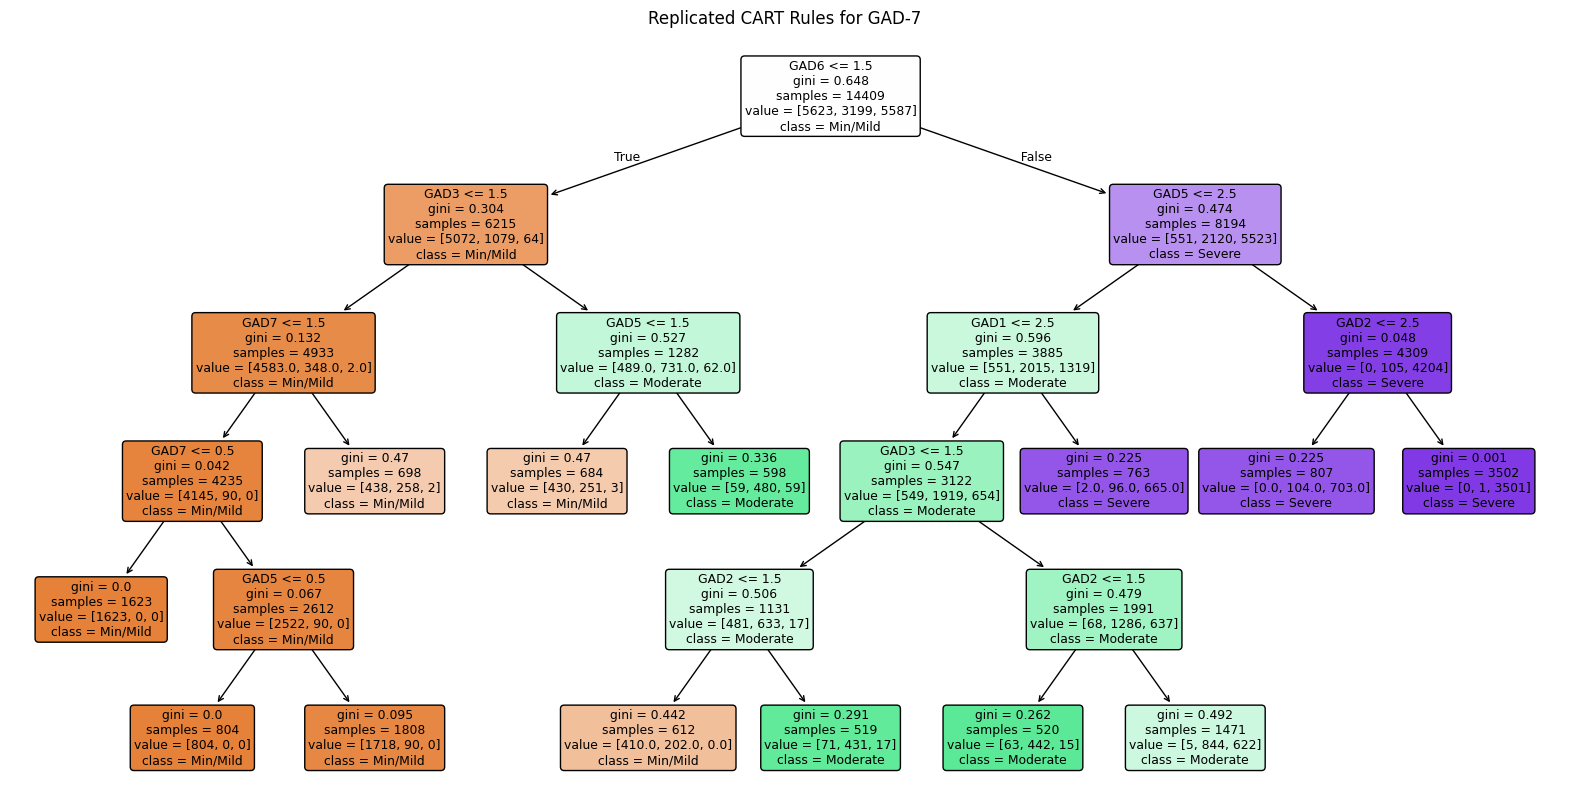

Classification Report:
               precision    recall  f1-score   support

    Min/Mild       0.86      0.95      0.90      2410
    Moderate       0.68      0.67      0.68      1371
      Severe       0.96      0.87      0.91      2395

    accuracy                           0.86      6176
   macro avg       0.83      0.83      0.83      6176
weighted avg       0.86      0.86      0.86      6176



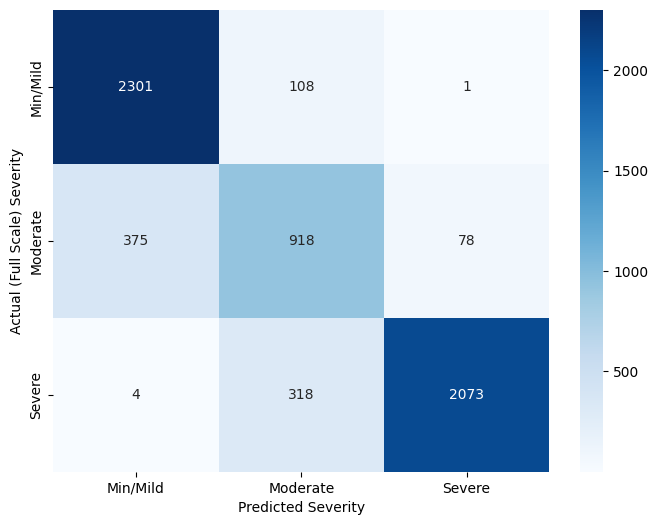

In [ ]:
# 4. Visualization of the Decision Rule
plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=X.columns, class_names=clf.classes_, filled=True, rounded=True)
plt.title("Replicated CART Rules for GAD-7")
plt.show()

# 5. Performance Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_, cmap='Blues')
plt.xlabel('Predicted Severity')
plt.ylabel('Actual (Full Scale) Severity')
plt.show()

In [ ]:
importances = pd.Series(clf.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))

GAD6    0.533555
GAD5    0.227932
GAD3    0.111409
GAD1    0.064918
GAD2    0.039878
GAD7    0.022308
GAD4    0.000000
dtype: float64


# Task
Train a DecisionTreeClassifier for PHQ-9 data with the same hyperparameters as the GAD-7 model, then calculate and plot One-vs-Rest (OvR) ROC curves and AUC scores for each severity class and the micro-average for both GAD-7 and PHQ-9 models.

## Train PHQ-9 Model

### Subtask:
Set up the data for PHQ-9, split it into training and testing sets, and train a DecisionTreeClassifier using the same hyperparameters as the GAD-7 model.


**Reasoning**:
To train the PHQ-9 model, I will first define the features and target variables from the `df_phq` dataframe, then split the data into training and testing sets, instantiate a `DecisionTreeClassifier` with the specified hyperparameters, fit the model to the training data, and finally make predictions on the test set.



In [ ]:
X_phq = df_phq.drop(['Total', 'Severity'], axis=1)
y_phq = df_phq['Severity']

X_phq_train, X_phq_test, y_phq_train, y_phq_test = train_test_split(X_phq, y_phq, test_size=0.3, random_state=42, stratify=y_phq)

clf_phq = DecisionTreeClassifier(
    criterion='gini',
    min_samples_leaf=500,
    min_samples_split=1000,
    random_state=42
)

clf_phq.fit(X_phq_train, y_phq_train)
y_phq_pred = clf_phq.predict(X_phq_test)

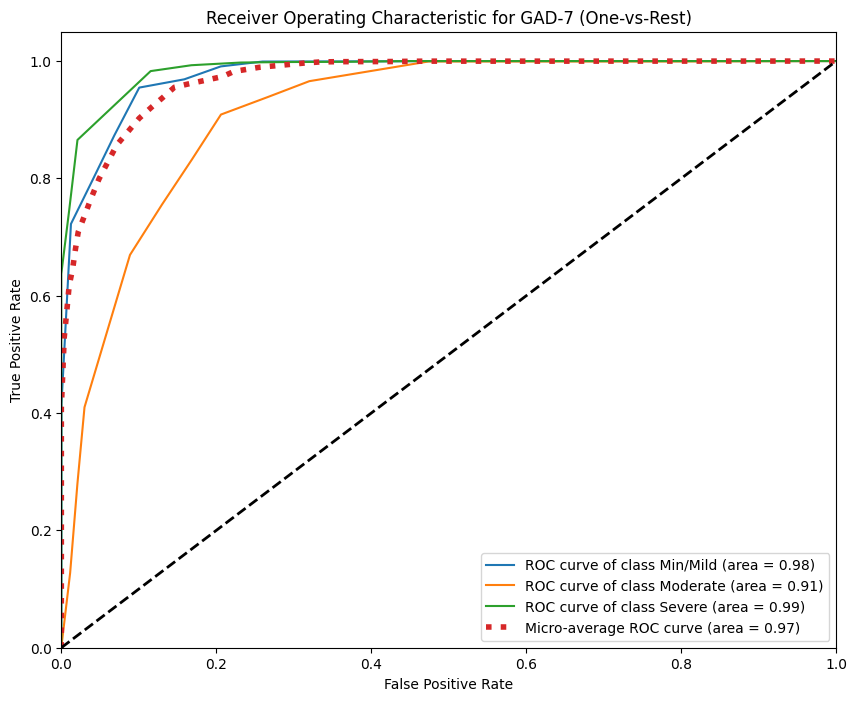

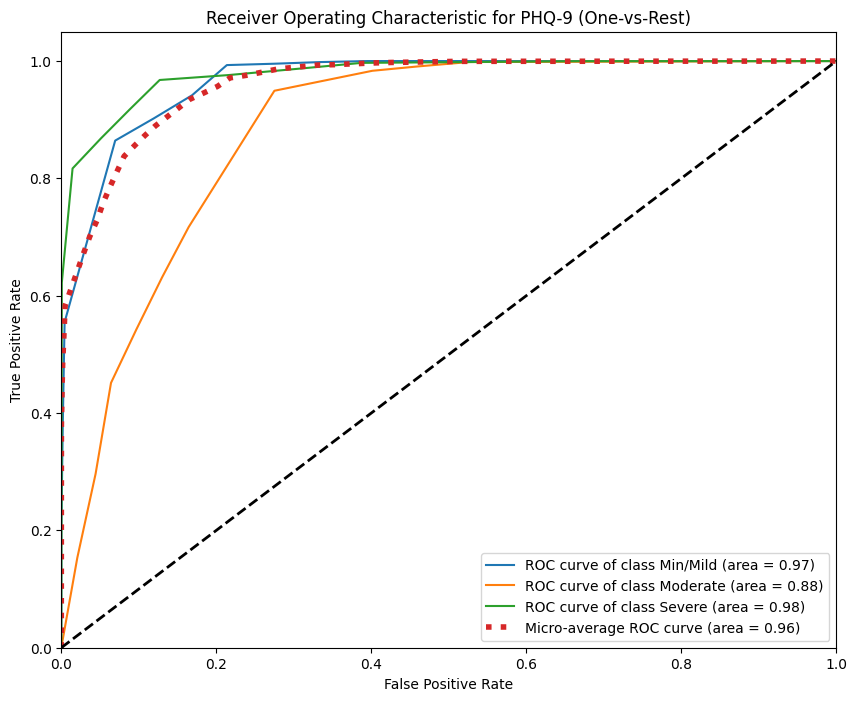

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

# --- GAD-7 ROC Curves ---

y_score_gad = clf.predict_proba(X_test)

# Binarize the output
label_binarizer_gad = LabelBinarizer()
y_test_binarized_gad = label_binarizer_gad.fit_transform(y_test)
classes_gad = label_binarizer_gad.classes_

plt.figure(figsize=(10, 8))
for i in range(len(classes_gad)):
    fpr, tpr, _ = roc_curve(y_test_binarized_gad[:, i], y_score_gad[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve of class {classes_gad[i]} (area = {roc_auc:.2f})')

# Micro-average ROC curve
fpr_micro_gad, tpr_micro_gad, _ = roc_curve(y_test_binarized_gad.ravel(), y_score_gad.ravel())
roc_auc_micro_gad = auc(fpr_micro_gad, tpr_micro_gad)
plt.plot(fpr_micro_gad, tpr_micro_gad, label=f'Micro-average ROC curve (area = {roc_auc_micro_gad:.2f})', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for GAD-7 (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()


# --- PHQ-9 ROC Curves ---

y_score_phq = clf_phq.predict_proba(X_phq_test)

# Binarize the output
label_binarizer_phq = LabelBinarizer()
y_test_binarized_phq = label_binarizer_phq.fit_transform(y_phq_test)
classes_phq = label_binarizer_phq.classes_

plt.figure(figsize=(10, 8))
for i in range(len(classes_phq)):
    fpr, tpr, _ = roc_curve(y_test_binarized_phq[:, i], y_score_phq[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve of class {classes_phq[i]} (area = {roc_auc:.2f})')

# Micro-average ROC curve
fpr_micro_phq, tpr_micro_phq, _ = roc_curve(y_test_binarized_phq.ravel(), y_score_phq.ravel())
roc_auc_micro_phq = auc(fpr_micro_phq, tpr_micro_phq)
plt.plot(fpr_micro_phq, tpr_micro_phq, label=f'Micro-average ROC curve (area = {roc_auc_micro_phq:.2f})', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for PHQ-9 (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

## Calculate and Plot ROC Curves

### Subtask:
For both GAD-7 and PHQ-9 models, predict probabilities on the test sets, binarize the true labels, and then calculate and plot the One-vs-Rest (OvR) ROC curves for each severity class, along with the micro-average ROC curve and AUC score.


## Summary:

### Data Analysis Key Findings

*   **PHQ-9 Data Preparation:** The 'Total' and 'Severity' columns were removed from the `df_phq` DataFrame to create the feature set `X_phq`, while the 'Severity' column was designated as the target variable `y_phq`.
*   **Data Splitting:** The PHQ-9 dataset was successfully split into training and testing sets, with 70% of the data allocated for training and 30% for testing. Stratified sampling was used to maintain the proportion of severity classes in both sets.
*   **Decision Tree Model Training (PHQ-9):** A Decision Tree Classifier (`clf_phq`) was initialized and trained on the PHQ-9 training data (`X_phq_train`, `y_phq_train`). The model utilized a 'gini' criterion, with `min_samples_leaf` set to 500 and `min_samples_split` set to 1000, consistent with the hyperparameters used for the GAD-7 model.
*   **Predictions Generated:** Following training, the model made predictions (`y_phq_pred`) on the PHQ-9 test dataset.

### Insights or Next Steps

*   The PHQ-9 model is now trained and ready for performance evaluation.
*   The next step should involve calculating and plotting the One-vs-Rest (OvR) ROC curves and AUC scores for each severity class and the micro-average for both the GAD-7 and newly trained PHQ-9 models, as outlined in the overall task.


# Task
Finalize the `respiratory` project for deployment to a GitHub repository by:

1.  **Cleaning and Documenting the Code**: Review all existing code cells in the notebook, adding comments, ensuring clear variable names, and optimizing for readability and efficiency.
2.  **Identifying Essential Project Files**: List all necessary files for the project, including this notebook (which will be saved as `respiratory_assessment.ipynb`), and any other relevant files.
3.  **Proposing a GitHub Repository Structure**: Outline a folder structure (e.g., `notebooks/`, `src/`, `data/`, `docs/`) and create a `requirements.txt` file listing all Python packages used (`pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`). Also, suggest a basic `README.md` file describing the project's purpose and contents.
4.  **Summarizing all the above points**: Provide a clear summary for the user to proceed with uploading the project to GitHub.

## Review and Clean Code

### Subtask:
Go through the existing code cells in the notebook, identify areas for improvement such as adding comments, ensuring clear variable names, optimizing code for efficiency, and removing any unused imports or variables. The goal is to make the code production-ready and easily understandable for others.


### Subtask:
Go through the existing code cells in the notebook, identify areas for improvement such as adding comments, ensuring clear variable names, optimizing code for efficiency, and removing any unused imports or variables. The goal is to make the code production-ready and easily understandable for others.

#### Instructions
1. Review all existing code cells, paying close attention to clarity and readability.
2. Add comments to explain complex logic, choices for specific parameters, or non-obvious steps within each code cell.
3. Ensure all variable names are descriptive and clearly indicate their purpose (e.g., `df_gad` for GAD-7 DataFrame, `clf_phq` for PHQ-9 classifier).
4. Check for and remove any unused import statements or variables that are no longer contributing to the functionality of the code.
5. Optimize code for efficiency where appropriate, for example, by ensuring operations are vectorized where possible instead of using loops.
6. Verify that the code consistently follows a clear and logical flow.

**Reasoning**:
The subtask is to review and clean existing code. I will start with the first code cell, `X5urHpsafWdd`, by adding comments to imports, improving variable naming for clarity (e.g., `N` to `num_observations`), and defining severity cutoffs as constants for better readability and maintainability. This directly addresses instructions 1, 2, and 3 of the subtask.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Generate Synthetic Data ---
# Set a random seed for reproducibility of data generation
np.random.seed(42)
# Define the number of observations for the synthetic dataset
num_observations = 20585

def generate_responses(n_items, n_obs):
    """
    Generates synthetic survey responses for a given number of items and observations.
    Simulates a latent trait (underlying distress) and maps it to item scores (0-3).
    """
    # Simulate a latent trait using a Gamma distribution to represent underlying distress
    latent_trait = np.random.gamma(shape=2, scale=2, size=n_obs)
    data = {}
    for i in range(1, n_items + 1):
        # Map the latent trait to a 0-3 scale with added Gaussian noise
        item_scores = np.clip(np.round(latent_trait * 0.5 + np.random.normal(0, 0.5, n_obs)), 0, 3)
        data[f'Item_{i}'] = item_scores.astype(int)
    return pd.DataFrame(data)

# Create GAD-7 and PHQ-9 dataframes using the synthetic data generator
df_gad = generate_responses(7, num_observations).rename(columns={f'Item_{i}': f'GAD{i}' for i in range(1, 8)})
df_phq = generate_responses(9, num_observations).rename(columns={f'Item_{i}': f'PHQ{i}' for i in range(1, 10)})

# --- 2. Define Ground Truth Severity ---
# Define cutoff points for GAD-7 severity classification as per clinical guidelines
GAD_CUTOFFS = [-1, 9, 14, 21]
GAD_LABELS = ['Min/Mild', 'Moderate', 'Severe']

# Calculate total GAD-7 score and assign severity based on cutoffs
df_gad['Total'] = df_gad.sum(axis=1) # Sum of all GAD item scores
df_gad['Severity'] = pd.cut(df_gad['Total'], bins=GAD_CUTOFFS, labels=GAD_LABELS)

# Define cutoff points for PHQ-9 severity classification as per clinical guidelines
PHQ_CUTOFFS = [-1, 9, 14, 27]
PHQ_LABELS = ['Min/Mild', 'Moderate', 'Severe'] # Labels consistent with GAD for comparison

# Calculate total PHQ-9 score and assign severity based on cutoffs
df_phq['Total'] = df_phq.sum(axis=1) # Sum of all PHQ item scores
df_phq['Severity'] = pd.cut(df_phq['Total'], bins=PHQ_CUTOFFS, labels=PHQ_LABELS)